# Echo State Network
Here, we validate the hyperparameters of the ESN. Note that the ESN is only trained on the encoded latent space representation. 

In [2]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from src.neuralnetwork.autoencoder import CAE
from src.neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split

sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

#### 1: Load the trained CAE and the encoded time series

In [29]:
model_path = Path('../weights/fluent-sweep-2/')
with open(model_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)
# Define some parameters for the data
# Define some parameters for the data
N_lyap = int(1/0.08/0.05)

N_lyap = int(1/ks_data["lyap"]/ks_data["dt"])
with open(model_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.05, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.04}
Encoded timeseries (399801, 8)


#### 2: Prepare the encoded data for the ESN training

In [30]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [31]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (39601, 8)


#### 3: Validate the hyperparameters of the ESN

In [32]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 5000,
        'dimension': dim,
        'reservoir_connectivity': 10,
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]),
        'input_bias': np.array([1]),
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]*2),
        'output_bias':  np.array([1]),
        'reservoir_weights_mode': "erdos_renyi1",
        # 'tikhonov': 1e-10,
        'input_normalization': [u_mean, norm],
        # 'input_weights_mode': 'dense',
        'input_seeds':[0, 1, 2],
        'reservoir_seeds':[3, 4]
    }


min_dict = validate(
    grid_range=grid_range,
    param_names=[key for key in hyperparameter_dict.keys()],
    param_scales=[values[-1] for values in hyperparameter_dict.values()],
    n_calls=20,  # number of total trials
    n_initial_points=10,  # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict,
    U_washout_train=U_washout,
    n_realisations=1,  # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label,
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5,  # number of folds, i.e., validation time series that start from random time instances
    N_washout_steps=N_washout,
    N_val_steps=N_val,
    random_seed=10,  # random seed for the bayesian optimization
    error_measure=errors.rel_L2)  # error measure to optimize over

esn_loaded_dict = dict(min_dict, **ESN_dict)

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-2.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-12.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 10)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 3.41033659841376
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  1.1551303594277162
Fold: 1 , fold error:  1.2740312260315148
Fold: 2 , fold error:  0.6869041581626624
Fold: 3 , fold error:  1.2123903337377213
Fold: 4 , fold error:  0.8978180163975477
Val regime error: 1.0452548187514323
Realisation error: 1.0452548187514323


Run 1 error: 1.0452548187514323


--NEW RUN-- 2
Realisation: 0
spectral_radius 0.8625265649057131
input_scaling 0.7424908231815013
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.19777e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9707252693458259
Fold: 1 , fold error:  0.9464333196621147
Fold: 2 , fold error:  0.8022824042212543
Fold: 3 , fold error:  1.0279580612091528
Fold: 4 , fold error:  0.9970401056854524
Val regime error: 0.94888783202476
Realisation error: 0.94888783202476


Run 2 error: 0.94888783202476


--NEW RUN-- 3
Realisation: 0
spectral_radius 0.3677811458900251
input_scaling 0.014795816345422881
tikhonov 9.999999999999999e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.36658e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.0810390006238277
Fold: 1 , fold error:  0.9460765560652672
Fold: 2 , fold error:  0.9996263897171324
Fold: 3 , fold error:  31183.985026781407
Fold: 4 , fold error:  1.0455471773525782
Val regime error: 6237.611463181033
Realisation error: 6237.611463181033


Run 3 error: 6237.611463181033


--NEW RUN-- 4
Realisation: 0
spectral_radius 0.529898605589215
input_scaling 2.732160361977424
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.78343e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1042949465737986
Fold: 1 , fold error:  1.0383989083114258
Fold: 2 , fold error:  1.0492037928374005
Fold: 3 , fold error:  1.1257894973583082
Fold: 4 , fold error:  1.1213952889652186
Val regime error: 1.0878164868092304
Realisation error: 1.0878164868092304


Run 4 error: 1.0878164868092304


--NEW RUN-- 5
Realisation: 0
spectral_radius 0.4535063164907469
input_scaling 3.2228217847874103
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.36296e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.143215361289479
Fold: 1 , fold error:  0.9111825283020807
Fold: 2 , fold error:  1.267412551088181
Fold: 3 , fold error:  1.177281440586422
Fold: 4 , fold error:  0.9611511344582733
Val regime error: 1.0920486031448873
Realisation error: 1.0920486031448873


Run 5 error: 1.0920486031448873


--NEW RUN-- 6
Realisation: 0
spectral_radius 0.6833546848460775
input_scaling 0.12726958252506762
tikhonov 0.001


Val regime: 0
Fold: 0 , fold error:  1.026983292359286
Fold: 1 , fold error:  0.9858962679850961
Fold: 2 , fold error:  0.9666577364478538
Fold: 3 , fold error:  1.028565305403822
Fold: 4 , fold error:  1.0177099563432195
Val regime error: 1.0051625117078555
Realisation error: 1.0051625117078555


Run 6 error: 1.0051625117078555


--NEW RUN-- 7
Realisation: 0
spectral_radius 0.22631570237138066
input_scaling 4.076259041096254
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.66718e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1581671045360895
Fold: 1 , fold error:  1.0229031516680283
Fold: 2 , fold error:  1.0250419450647008
Fold: 3 , fold error:  0.9838822760652566
Fold: 4 , fold error:  0.9902448280463206
Val regime error: 1.0360478610760793
Realisation error: 1.0360478610760793


Run 7 error: 1.0360478610760793


--NEW RUN-- 8
Realisation: 0
spectral_radius 0.82081967678168
input_scaling 0.3642775765463243
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  1.417365480001125
Fold: 1 , fold error:  1.1080590148036
Fold: 2 , fold error:  1.2529741663947631
Fold: 3 , fold error:  1.1359020588187305
Fold: 4 , fold error:  1.0772210989504043
Val regime error: 1.1983043637937245
Realisation error: 1.1983043637937245


Run 8 error: 1.1983043637937245


--NEW RUN-- 9
Realisation: 0
spectral_radius 0.7485693892533252
input_scaling 0.5572619319129042
tikhonov 1e-07




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03008e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.0892052250349737
Fold: 1 , fold error:  0.8241536341834518
Fold: 2 , fold error:  1.0954072629311251
Fold: 3 , fold error:  1.1083016584074015
Fold: 4 , fold error:  1.104782375403359
Val regime error: 1.0443700311920623
Realisation error: 1.0443700311920623


Run 9 error: 1.0443700311920623


--NEW RUN-- 10
Realisation: 0
spectral_radius 0.7827540618901216
input_scaling 0.020783697921338138
tikhonov 1e-08


Val regime: 0
Fold: 0 , fold error:  1087.1014089257724
Fold: 1 , fold error:  1162.5484545424663
Fold: 2 , fold error:  1.107307123612198
Fold: 3 , fold error:  1.0441908484549398
Fold: 4 , fold error:  0.9111204602706814
Val regime error: 450.54249638011527
Realisation error: 450.54249638011527


Run 10 error: 450.54249638011527


--NEW RUN-- 11
Realisation: 0
spectral_radius 1.0
input_scaling 10.0
tikhonov 1e-12


Val regime: 0
Fold: 0 , fold error:  1.233192883813918
Fold: 1 , fold error:  1.4622425291779086
Fold: 2 , fold error:  1.225157

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.38066e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1205658246037422
Fold: 1 , fold error:  1.0609292710384168
Fold: 2 , fold error:  1.158356777931837
Fold: 3 , fold error:  1.141209027633455
Fold: 4 , fold error:  1.0637462778028624
Val regime error: 1.1089614358020627
Realisation error: 1.1089614358020627


Run 13 error: 1.1089614358020627


--NEW RUN-- 14
Realisation: 0
spectral_radius 0.10341259681042397
input_scaling 3.043617848709693
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16033e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.1769355389054588
Fold: 1 , fold error:  1.20577925888503
Fold: 2 , fold error:  0.9136629891049789
Fold: 3 , fold error:  1.1510315629055823
Fold: 4 , fold error:  1.2215807097197928
Val regime error: 1.1337980119041684
Realisation error: 1.1337980119041684


Run 14 error: 1.1337980119041684


--NEW RUN-- 15
Realisation: 0
spectral_radius 0.10913859468537243
input_scaling 5.254274101402077
tikhonov 1e-08




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74918e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9500115164642028
Fold: 1 , fold error:  0.9960631395959824
Fold: 2 , fold error:  0.9241574168405803
Fold: 3 , fold error:  1.0749396149002244
Fold: 4 , fold error:  1.1284787350763288
Val regime error: 1.0147300845754637
Realisation error: 1.0147300845754637


Run 15 error: 1.0147300845754637


--NEW RUN-- 16
Realisation: 0
spectral_radius 0.6956814774602812
input_scaling 0.14275035129718425
tikhonov 0.001


Val regime: 0
Fold: 0 , fold error:  0.930037713879147
Fold: 1 , fold error:  0.9891616778877992
Fold: 2 , fold error:  1.035301633490368
Fold: 3 , fold error:  0.9851740375423688
Fold: 4 , fold error:  0.956316417038787
Val regime error: 0.9791982959676939
Realisation error: 0.9791982959676939


Run 16 error: 0.9791982959676939


--NEW RUN-- 17
Realisation: 0
spectral_radius 0.7350008465321488
input_scaling 1.1160631986323566
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.56033e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9286983807569099
Fold: 1 , fold error:  1.180748776220858
Fold: 2 , fold error:  1.065376236969283
Fold: 3 , fold error:  1.2355375671625437
Fold: 4 , fold error:  1.414473936309729
Val regime error: 1.1649669794838649
Realisation error: 1.1649669794838649


Run 17 error: 1.1649669794838649


--NEW RUN-- 18
Realisation: 0
spectral_radius 0.8998780062567542
input_scaling 0.6641015824831641
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.44006e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.120114817870015
Fold: 1 , fold error:  1.1200627302009807
Fold: 2 , fold error:  1.005083397240059
Fold: 3 , fold error:  1.028707665728219
Fold: 4 , fold error:  0.9455504389614118
Val regime error: 1.0439038100001372
Realisation error: 1.0439038100001372


Run 18 error: 1.0439038100001372


--NEW RUN-- 19
Realisation: 0
spectral_radius 0.27912825371713645
input_scaling 5.511181698153896
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  1.22832101096328
Fold: 1 , fold error:  0.9909090594729965
Fold: 2 , fold error:  1.1010119787751427
Fold: 3 , fold error:  1.1837100669962057
Fold: 4 , fold error:  1.255358491874712
Val regime error: 1.1518621216164673
Realisation error: 1.1518621216164673


Run 19 error: 1.1518621216164673


--NEW RUN-- 20
Realisation: 0
spectral_radius 0.9212748428744022
input_scaling 0.797958067103133
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.73406e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9830006265615074
Fold: 1 , fold error:  0.9933519204651965
Fold: 2 , fold error:  1.1842804680629688
Fold: 3 , fold error:  0.9303535828711958
Fold: 4 , fold error:  0.8918196534940073
Val regime error: 0.9965612502909751
Realisation error: 0.9965612502909751


Run 20 error: 0.9965612502909751


{'f': array([0.94888783, 0.9791983 , 0.98330447, 0.99656125, 1.00516251]), 'spectral_radius': array([0.86252656, 0.69568148, 0.68466838, 0.92127484, 0.68335468]), 'input_scaling': array([0.74249082, 0.14275035, 0.12883642, 0.79795807, 0.12726958]), 'tikhonov': array([1.e-09, 1.e-03, 1.e-03, 1.e-09, 1.e-03])}


In [41]:
with open(model_path / 'esn_best_dict.pkl', 'wb') as f:
    pickle.dump(esn_loaded_dict, f)


#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [34]:
# with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
#     esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'f': array([0.94888783, 0.9791983 , 0.98330447, 0.99656125, 1.00516251]), 'spectral_radius': array([0.86252656, 0.69568148, 0.68466838, 0.92127484, 0.68335468]), 'input_scaling': array([0.74249082, 0.14275035, 0.12883642, 0.79795807, 0.12726958]), 'tikhonov': array([1.e-09, 1.e-03, 1.e-03, 1.e-09, 1.e-03]), 'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([-0.00593858, -0.04789577,  0.01191856,  0.03158609, -0.03616858,
        0.04105314, -0.00360776,  0.01144325]), array([1.11553235, 1.08183018, 1.10016882, 1.06189767, 1.08552729,
       1.07920115, 1.16133172, 1.06537837])], 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4]}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.90761e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### 5: CAE-ESN prediction on the test data

In [35]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(model_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

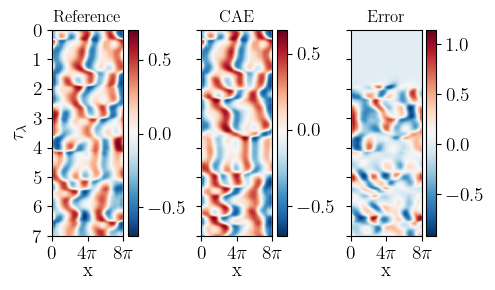

In [39]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/((ks_data["dt"])*ks_data["upsample"]))
N_plot = 7*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], N_plot)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+N_plot, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (((ks_data["dt"])*ks_data["upsample"])))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)
